In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet


from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb


In [2]:
df=pd.read_csv('Train_rev1.csv')

In [3]:
df.shape

(244768, 12)

In [4]:
# sampling 2500 rows to make the data more manageable
df = df.sample(2500, random_state=42)
df.shape

(2500, 12)

In [5]:
df.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
30390,68062598,Business Account Manager,Business Account Manager Plumbing Heating Pro...,South West,South West London,NaN,permanent,BMS Sales Specialists,Sales Jobs,"22000 - 25000 per annum + Car,Mobile,Pension,L...",23500,totaljobs.com
108709,69622111,Staff Nurse RGN/RMN Newtown Abbey Nights Ne...,Job Title; Staff Nurse RGN/RMN – NightsLocatio...,Newtownabbey,Newtownabbey,full_time,NaN,Regional Recruitment Services,Healthcare & Nursing Jobs,12.00/Hour,23040,staffnurse.com
13924,66664026,Community Fundraising Manager,This dynamic international development charity...,London,London,full_time,permanent,TPP Not for Profit,Charity & Voluntary Jobs,33300 - 36400 per annum,34850,Third Sector Jobs
154606,71015241,Conveyancing Executive,Large regional law firm require a residential ...,Hampshire,Hampshire,full_time,permanent,PTP Consulting,Legal Jobs,"From 18,000 to 27,000 per year",22500,TotallyLegal
172891,71428553,Investment Compliance Analyst,This individual will work closely with the bus...,London South East,South East London,NaN,permanent,Michael Page Financial Services,Accounting & Finance Jobs,50000 to 60000 per annum,55000,totaljobs.com


In [6]:
df.columns

Index(['Id', 'Title', 'FullDescription', 'LocationRaw', 'LocationNormalized',
       'ContractType', 'ContractTime', 'Company', 'Category', 'SalaryRaw',
       'SalaryNormalized', 'SourceName'],
      dtype='object')

In [7]:
# Reading some of the job descriptions to understand the data
job_desc=df.FullDescription.tolist()
job_desc[0:5]

["Business Account Manager  Plumbing Heating Products  Basic Salary ******** South West THE COMPANY : We are currently recruiting due to internal promotion for a very wellknown construction group, with a history stretching back to the ****'s and a turnover in excess of 300 million. You will be selling plumbing and heating products into plumbing and heating contractors, dealing with every sector from SMEs to 1man bands and right up to larger contractors. This role is an even split between account management and new business development and you will inherit some excellent accounts. Sales career opportunities within the group are excellent. THE PERSON : You will have the following skills; Field sales track record You will have sold a construction or industrial product They seek someone with excellent organisational and account development skills You will receive full product training THE PACKAGE : Basic Salary ********  30% Bonuses Fully Expensed Company Car Mobile, Pension, Laptop South 

In [8]:
# Selecting only the columns that we need
df2=df[['FullDescription','SalaryNormalized']]

In [9]:
# checking for missing values
df2.isna().sum()

FullDescription     0
SalaryNormalized    0
dtype: int64

In [10]:
# checking for duplicates
df2.duplicated().sum()

0

In [11]:
# checking the descriptive statistics of the salary
df2['SalaryNormalized'].describe()


count      2500.000000
mean      33764.077200
std       16670.019292
min        5088.000000
25%       21500.000000
50%       30000.000000
75%       42500.000000
max      100000.000000
Name: SalaryNormalized, dtype: float64

In [12]:
# converting the target variable to a binary varable with high salary as 1 and low salary as 0
# using the 75th percentile as the threshold
df2['SalaryLevel']=df2['SalaryNormalized'].apply(lambda x: 'High' if x>=df2['SalaryNormalized'].quantile(0.75) else 'Low')
# Coverting the newly created column to a categorical variable
df2.SalaryLevel.astype('object')

/var/folders/rj/g3r71fsx2vnbbbjb9v368gr00000gp/T/ipykernel_910/1729276314.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['SalaryLevel']=df2['SalaryNormalized'].apply(lambda x: 'High' if x>=df2['SalaryNormalized'].quantile(0.75) else 'Low')


30390      Low
108709     Low
13924      Low
154606     Low
172891    High
          ... 
71198      Low
214477     Low
132982     Low
63578      Low
41373      Low
Name: SalaryLevel, Length: 2500, dtype: object

In [13]:
# Verifying the the new column
df2.sample(20)

,FullDescription,SalaryNormalized,SalaryLevel
60766,Baptie Co is one of the World’s leading provid...,22500,Low
218552,Estate Agent Branch Manager Exclusive & Countr...,37500,Low
177423,We are looking for an experienced Chef De Part...,16000,Low
88506,A Senior Database Administrator is required fo...,62499,High
243419,We are looking for a Scrub and Endoscopy Nurse...,26000,Low
36987,"Professional Services, Law firm seeking a new ...",70000,High
63031,The Company: My client is a reputable regional...,30000,Low
33764,Maths Teacher Do you want to join an “OUTSTAND...,29172,Low
121429,A Degree qualified Software Test Engineer is s...,35000,Low
113210,A new opportunity has arisen for a home based ...,45000,High


/Users/Abdul/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Abdul/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/Abdul/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Abdul/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance

The Proportion of High Salary Jobs is:
 SalaryLevel
Low     0.7424
High    0.2576
Name: proportion, dtype: float64


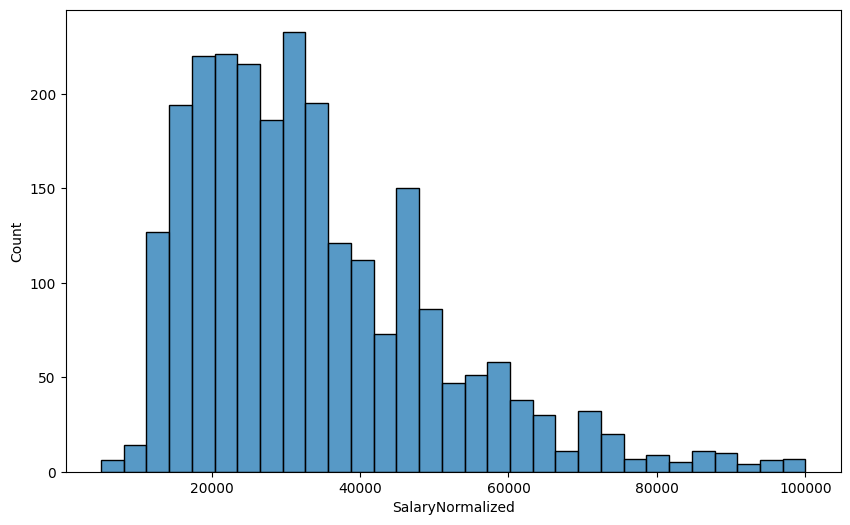

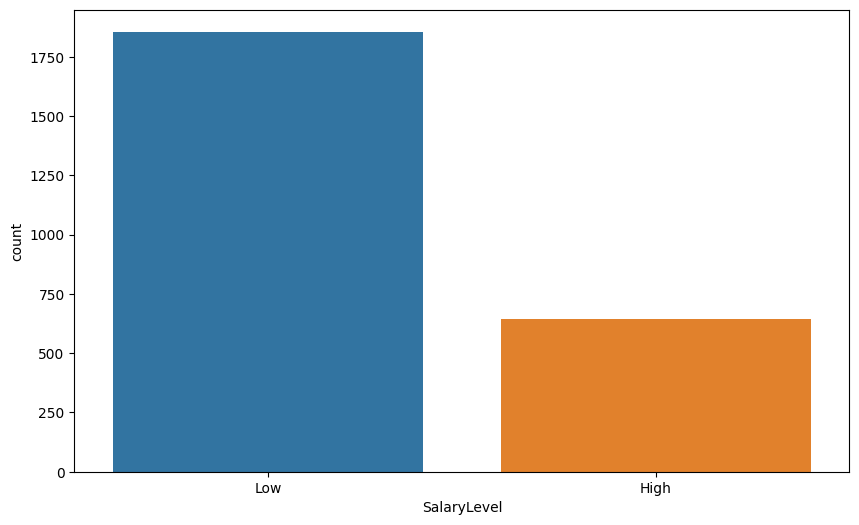

In [14]:
# viewing the distribution of the salaries
plt.subplots(figsize=(10,6))
sns.histplot(df2['SalaryNormalized']);

# viewing the distribution of the binary target variable
plt.subplots(figsize=(10,6))
sns.countplot(x='SalaryLevel', data=df2); 
print('The Proportion of High Salary Jobs is:\n' ,df2['SalaryLevel'].value_counts(normalize=True))


In [15]:
# encoding the categorical variable without dropping the first column because I want to retain high salary as the reference category
cat_cols = ['SalaryLevel']
df2 = pd.get_dummies(df2, columns=cat_cols, drop_first=False, dtype='int64')

# Now dropping the 'SalaryLevel_Low' column manually
df2.drop('SalaryLevel_Low', axis=1, inplace=True)

df2.head()

,FullDescription,SalaryNormalized,SalaryLevel_High
30390,Business Account Manager Plumbing Heating Pro...,23500,0
108709,Job Title; Staff Nurse RGN/RMN – NightsLocatio...,23040,0
13924,This dynamic international development charity...,34850,0
154606,Large regional law firm require a residential ...,22500,0
172891,This individual will work closely with the bus...,55000,1


In [16]:
# dropping the numerical salary column
df2.drop('SalaryNormalized', axis=1, inplace=True)

### Model Building
- Both Count Vectorizer and TF-IDF were tested to identify which technique provides better performance.
- Count Vectorizer emerged as the superior method, yielding the highest accuracy.
- Despite experimenting with a variation of Count Vectorizer, including altering n-grams, and adjusting the maximum and minimum document frequency, these modifications did not enhance the results.
- Additionally, experimentation with lemmatization was done.
- However, altering the hyperparameters in the vectorizer did not lead to any improvement in outcomes, neither did lemmatization


In [45]:
# instantiating the count vectorizer
cv=CountVectorizer(stop_words='english')
# fitting and transforming the full description column and assigning it to X
X=cv.fit_transform(df2['FullDescription'])
# assigning the target variable to y
y=df2['SalaryLevel_High']

In [46]:
# checking the dimensions of the X matrix
X.shape

(2500, 17693)

In [47]:
# splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
# instantiating the multinomial naive bayes model
NB1=MultinomialNB()
# fitting the model to the training data
NB1.fit(X_train, y_train)
# making predictions
y_pred1=NB1.predict(X_test)

In [49]:
# evaluating the model
print(classification_report(y_test, y_pred1, target_names=['Low Salary', 'High Salary']))

              precision    recall  f1-score   support

  Low Salary       0.87      0.83      0.85       368
 High Salary       0.58      0.66      0.61       132

    accuracy                           0.78       500
   macro avg       0.72      0.74      0.73       500
weighted avg       0.79      0.78      0.79       500



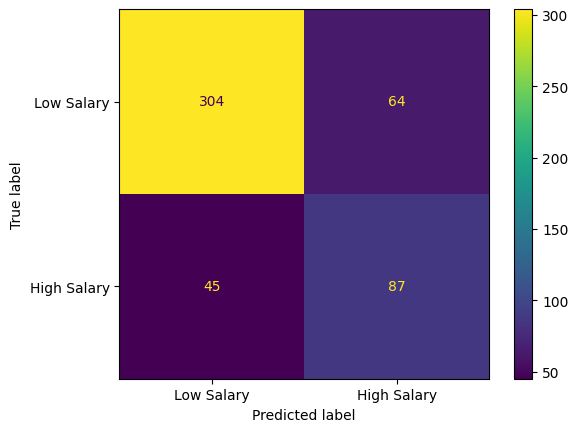

In [50]:
cm1=confusion_matrix(y_test, y_pred1)
ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=['Low Salary', 'High Salary']).plot();
                            

In [51]:
# using tfidf vectorizer
# instantiating the tfidf vectorizer
tfidf=TfidfVectorizer(stop_words='english', max_features=1000)
# fitting and transforming the full description column and assigning it to X
X=tfidf.fit_transform(df2['FullDescription'])
# splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [52]:
# instantiating the multinomial naive bayes model
NB2=MultinomialNB()
# fitting the model to the training data
NB2.fit(X_train, y_train)
# making predictions
y_pred2=NB2.predict(X_test)


In [53]:
print(classification_report(y_test, y_pred2, target_names=['Low Salary', 'High Salary']))

              precision    recall  f1-score   support

  Low Salary       0.80      0.93      0.86       368
 High Salary       0.65      0.35      0.45       132

    accuracy                           0.78       500
   macro avg       0.72      0.64      0.66       500
weighted avg       0.76      0.78      0.75       500



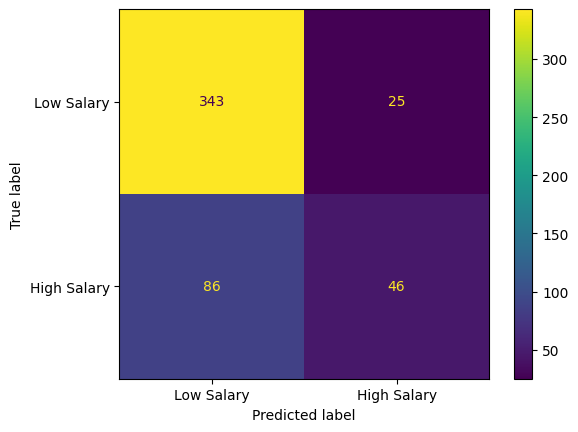

In [54]:
cm2=confusion_matrix(y_test, y_pred2)
ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=['Low Salary', 'High Salary']).plot();

In [55]:
# Using count vectorizer experimenting with different max document frequency, minimum doc freq and ngram range
# instantiating the count vectorizer
cv=CountVectorizer(stop_words='english', max_df=0.8, min_df=2, ngram_range=(1,3))
# fitting and transforming the full description column and assigning it to X
X=cv.fit_transform(df2['FullDescription'])
# splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
# instantiating the multinomial naive bayes model
NB3=MultinomialNB()
# fitting the model to the training data
NB3.fit(X_train, y_train)
# making predictions
y_pred3=NB3.predict(X_test)

In [57]:
print(classification_report(y_test, y_pred3, target_names=['Low Salary', 'High Salary']))

              precision    recall  f1-score   support

  Low Salary       0.89      0.77      0.83       368
 High Salary       0.54      0.73      0.62       132

    accuracy                           0.76       500
   macro avg       0.71      0.75      0.72       500
weighted avg       0.80      0.76      0.77       500



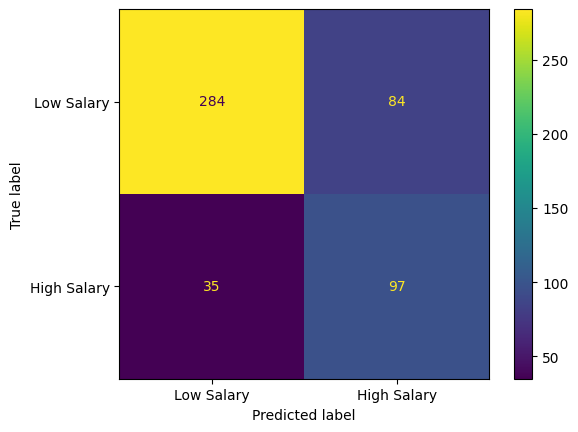

In [58]:
cm3=confusion_matrix(y_test, y_pred3)
ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=['Low Salary', 'High Salary']).plot();

In [59]:
# defining a function to lemmatize the text
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:         
        return wordnet.NOUN
       
def lemmatize_passage(text):
    words = word_tokenize(text)
    pos_tags = pos_tag(words)
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]
    lemmatized_sentence = ' '.join(lemmatized_words)
    return lemmatized_sentence

In [60]:
# lemmatizing the full description column
lemma_desc=df2['FullDescription'].apply(lemmatize_passage)


In [61]:
# instantiating the count vectorizer
cv=CountVectorizer(stop_words='english')
# fitting and transforming the full description column and assigning it to X
X=cv.fit_transform(lemma_desc)
# splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [62]:
# instantiating the multinomial naive bayes model
NB4=MultinomialNB()
# fitting the model to the training data
NB4.fit(X_train, y_train)
# making predictions
y_pred4=NB4.predict(X_test)

In [63]:
print(classification_report(y_test, y_pred4, target_names=['Low Salary', 'High Salary']))   


              precision    recall  f1-score   support

  Low Salary       0.86      0.82      0.84       368
 High Salary       0.56      0.64      0.60       132

    accuracy                           0.77       500
   macro avg       0.71      0.73      0.72       500
weighted avg       0.78      0.77      0.78       500



In [64]:
confusion_matrix(y_test, y_pred4)

array([[302,  66],
       [ 48,  84]])

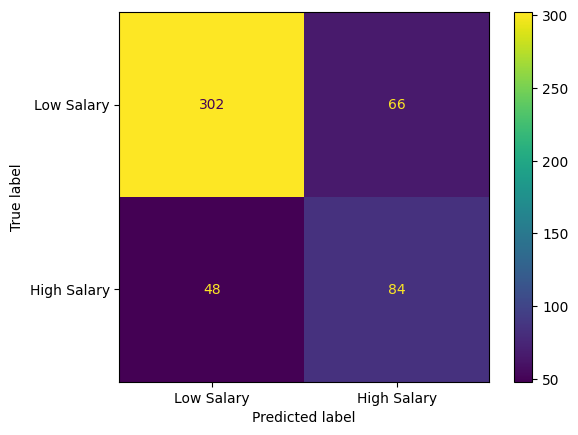

In [65]:
cm4=confusion_matrix(y_test, y_pred4)
ConfusionMatrixDisplay(confusion_matrix=cm4, display_labels=['Low Salary', 'High Salary']).plot();

### Exploring the Top 10 Words that are Most Indicative of HIGH Salary and Those Indicative of Low Salary
- A logistic regression model was trained on text transformed by Count Vectorizer.
- The coefficients from the logistic regression were used to identify the most influential words. Words with the highest coefficients, indicating a positive correlation with the log odds, suggest a high salary. These top words for high salary include: director, senior, leadership, dentist, consumer, player, reputation, lead, successfully, and image.
- Conversely, words with the lowest coefficients, typically negative, were deemed most indicative of a low salary. These words include: applicants, standard, basic, database, hours, depending, timely, selling, building, and stock.





In [66]:
# instatiating the count vectorizer
cv=CountVectorizer(stop_words='english')
# fitting and transforming the full description column and assigning it to X
X=cv.fit_transform(df2['FullDescription'])
# splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [67]:
# instantiating the logistic regression model
logreg=LogisticRegression(max_iter=10000, random_state=42)
# fitting the model to the training data
logreg.fit(X_train, y_train)
# making predictions
y_pred5=logreg.predict(X_test)

print(classification_report(y_test, y_pred5, target_names=['Low Salary', 'High Salary']))

              precision    recall  f1-score   support

  Low Salary       0.85      0.88      0.86       368
 High Salary       0.63      0.55      0.59       132

    accuracy                           0.80       500
   macro avg       0.74      0.72      0.73       500
weighted avg       0.79      0.80      0.79       500



In [68]:
logreg.coef_

array([[-8.84968233e-02,  5.66633100e-03, -1.18142826e-02, ...,
        -7.67680432e-05, -3.99000380e-03,  1.99684785e-01]])

In [69]:
# Assessing the coefficients to see the words that are most associated with high salary
coefficients=pd.DataFrame({'Word':cv.get_feature_names_out(), 'Coefficient':logreg.coef_[0]})
coefficients


,Word,Coefficient
0,00,-0.088497
1,000,0.005666
2,001,-0.011814
3,008,0.018958
4,00am,-0.124951
...,...,...
17688,zoo,-0.002369
17689,zoos,-0.036458
17690,zorin,-0.000077
17691,zq,-0.003990


In [70]:
# Printing the top 10 words that are most associated with high salary
coefficients.sort_values(by='Coefficient', ascending=False).head(10)

,Word,Coefficient
4779,director,0.988911
14323,senior,0.955226
9078,leadership,0.746034
4503,dentist,0.705865
3706,consumer,0.646954
11991,player,0.586595
13445,reputation,0.576114
9075,lead,0.568520
15455,successfully,0.561347
7875,image,0.558177


In [71]:
# printing the top 10 words that are most associated with low salary
coefficients.sort_values(by='Coefficient', ascending=True).head(10)

,Word,Coefficient
1129,applicants,-0.951040
15151,standard,-0.677674
1732,basic,-0.644806
4255,database,-0.580449
7656,hours,-0.573575
4523,depending,-0.556597
16114,timely,-0.553824
14301,selling,-0.541564
2363,building,-0.532247
15253,stock,-0.531779
